<a href="https://colab.research.google.com/github/GianmarcoLuchetti/Healthcare-Dataset-Prediction/blob/main/Healthcare_Dataset_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [4]:
# Load the dataset https://www.kaggle.com/datasets/prasad22/healthcare-dataset/data
df = pd.read_csv('/content/healthcare_dataset.csv')
pd.set_option('display.max_columns', None)

# Exploratory Data Analysis

The graphs obtained in this section highlight a general balance between the main features, as well as a balance between the number of classes in the "**Test Results**" column.

In [5]:
#  Generale information
print(f'Dataframe first five rows: \n {df.head()} \n \n')
print(f'Dataframe shape (rows, columns): {df.shape} \n \n')
print(df.info(), '\n \n')
print(df.describe(), '\n \n')
print(f'Missing values in the dataset: \n {df.isnull().sum()} \n \n')
print(f'Duplicate values in the dataset: \n {df.isnull().sum()} \n \n')

Dataframe first five rows: 
                   Name  Age  Gender Blood Type Medical Condition  \
0      Tiffany Ramirez   81  Female         O-          Diabetes   
1          Ruben Burns   35    Male         O+            Asthma   
2            Chad Byrd   61    Male         B-           Obesity   
3    Antonio Frederick   49    Male         B-            Asthma   
4  Mrs. Brandy Flowers   51    Male         O-         Arthritis   

  Date of Admission          Doctor                   Hospital  \
0        2022-11-17  Patrick Parker           Wallace-Hamilton   
1        2023-06-01   Diane Jackson  Burke, Griffin and Cooper   
2        2019-01-09      Paul Baker                 Walton LLC   
3        2020-05-02  Brian Chandler                 Garcia Ltd   
4        2021-07-09  Dustin Griffin    Jones, Brown and Murray   

  Insurance Provider  Billing Amount  Room Number Admission Type  \
0           Medicare    37490.983364          146       Elective   
1   UnitedHealthcare    47304

## Plots


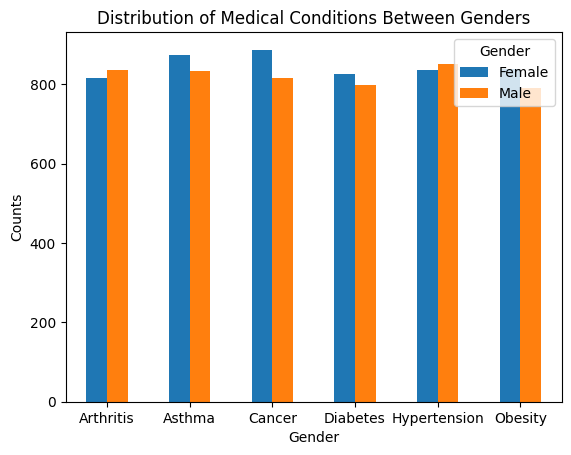

In [6]:
# Distribution of Medical Conditions Between Genders
gender_patology = df.groupby(['Medical Condition', 'Gender']).size().sort_values().unstack()
gender_patology.plot(kind='bar')
plt.title('Distribution of Medical Conditions Between Genders')
plt.xlabel('Gender')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.show()

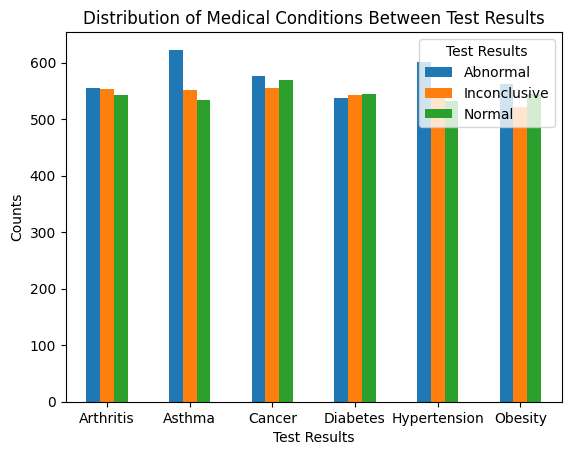

In [7]:
# Distribution of Medical Conditions Between Test Results
test_patology = df.groupby(['Medical Condition', 'Test Results']).size().sort_values().unstack()
test_patology.plot(kind='bar')
plt.title('Distribution of Medical Conditions Between Test Results')
plt.xlabel('Test Results')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.show()

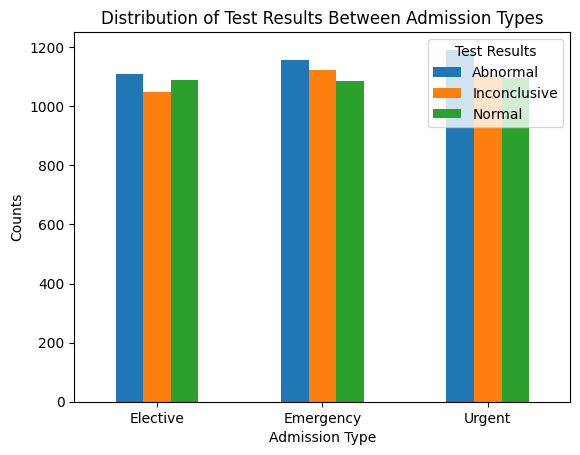

In [8]:
# Distribution of Test Results Between Admission Types
admission_patology = df.groupby(['Admission Type', 'Test Results']).size().sort_values().unstack()
admission_patology.plot(kind='bar')
plt.title('Distribution of Test Results Between Admission Types')
plt.xlabel('Admission Type')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.show()

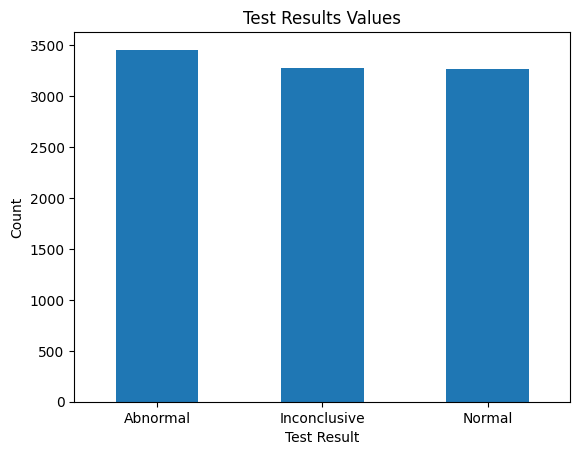

In [9]:
# Bar plot to visualize occurrences of each value in 'Test Results' column
result_counts = df['Test Results'].value_counts()
ax = result_counts.plot(kind='bar')
plt.title('Test Results Values')
plt.xlabel('Test Result')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Feature Engineering

In this section, transformations were applied to the nonnumerical features provided in the dataset. These were considered important for the purpose of prediction, so they were transformed according to the following principles:
- "**Gender**" column, containing only two possible values these were coded as 0 and 1;
- "**Addmission Type**" and "**Test Results**" column, these were considered ordinal variables, and therefore coded within the same column in order to create order among the features;
- Column "**Blood Type**", "**Medical Condition**", and "**Medication**", these were considered non ordinal variables, and therefore coded in different columns by One Hot Encoding;

Finally, the duration of hospitalization was considered important, which was calculated by considering the two columns "**Date of Admission**" and "**Discharge Date**".

In [10]:
# Drop useless columns
df.drop(['Name', 'Doctor', 'Hospital',
            'Insurance Provider', 'Room Number'], axis=1, inplace=True)

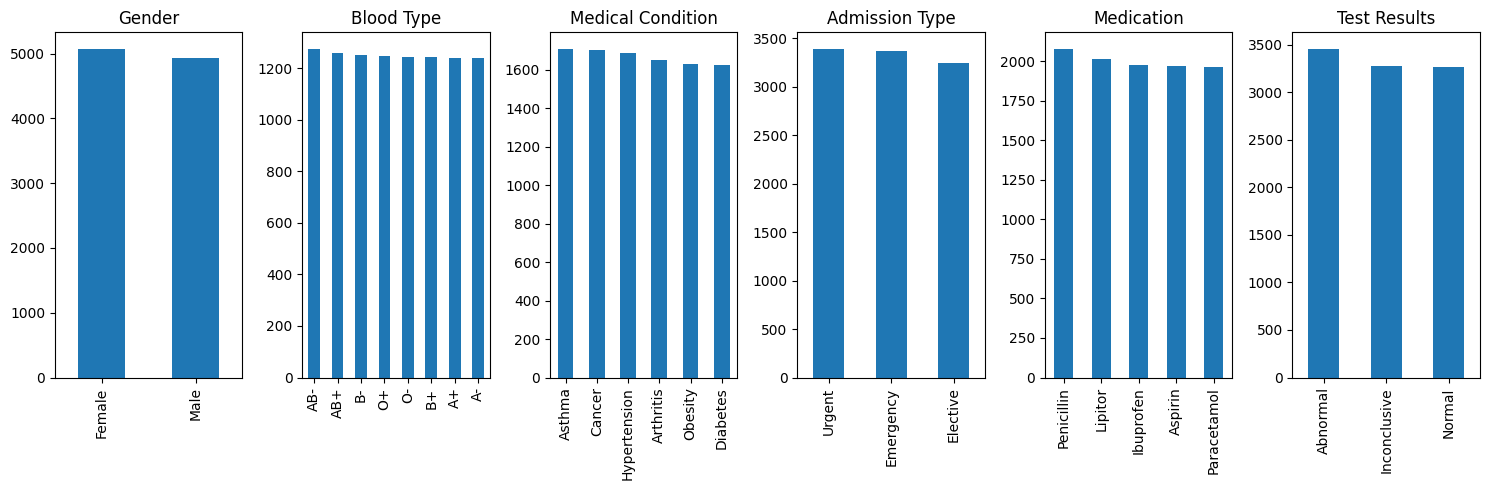

In [11]:
# Bar plot to see the types of values in columns contained in columns_to_plot
columns_to_plot = ['Gender', 'Blood Type', 'Medical Condition', 'Admission Type',
                    'Medication', 'Test Results']
fig, axs = plt.subplots(nrows=1, ncols=len(columns_to_plot), figsize=(15, 5))
for i, col in enumerate(columns_to_plot):
    value_counts = df[col].value_counts()
    value_counts.plot(kind='bar', ax=axs[i])
    axs[i].set_title(col)
plt.tight_layout()
plt.show()

In [12]:
# Encoding the Gender feature: Female -> 0, Male -> 1
le = preprocessing.LabelEncoder()
le.fit(df['Gender'])
df['Gender'] = le.transform(df['Gender'])

In [13]:
# Encoding the Addmission Type feature: Emergency -> 0, Elective -> 1, Urgent -> 2
mapper_at = dict({'Emergency': 0, 'Elective': 1, 'Urgent': 2})
df['Admission Type'] = df['Admission Type'].map(mapper_at)

In [14]:
# Encoding the Test Results feature: Normal -> 0, Abnormal -> 1, Inconclusive -> 2
mapper_tr = dict({'Normal': 0, 'Abnormal': 1, 'Inconclusive': 2})
df['Test Results'] = df['Test Results'].map(mapper_tr)

In [15]:
# One Hot Encoding of non-categorical features
df = pd.get_dummies(df, columns=['Blood Type', 'Medical Condition', 'Medication'], dtype=int)

In [16]:
# New feature: hospitalization time
df['Date of Admission'] = pd.to_datetime(df['Date of Admission'])
df['Discharge Date'] = pd.to_datetime(df['Discharge Date'])
df.insert(5, 'Hospitalization Time', (df['Discharge Date'] - df['Date of Admission']).dt.days)
df.drop(['Date of Admission', 'Discharge Date'], axis=1, inplace=True)

In [17]:
# Move label column to the last position
columns = list(df.columns)
columns.remove('Test Results')  # Remove the column
columns.append('Test Results')  # Append it to the end
df = df[columns]

In [18]:
# Definitive dataset info
print(f'Final Dataset Head: \n {df.head()} \n \n')
print(f'Final Dataset Shape: {df.shape} \n \n')

Final Dataset Head: 
    Age  Gender  Billing Amount  Admission Type  Hospitalization Time  \
0   81       0    37490.983364               1                    14   
1   35       1    47304.064845               0                    14   
2   61       1    36874.896997               0                    30   
3   49       1    23303.322092               2                     1   
4   51       1    18086.344184               2                    24   

   Blood Type_A+  Blood Type_A-  Blood Type_AB+  Blood Type_AB-  \
0              0              0               0               0   
1              0              0               0               0   
2              0              0               0               0   
3              0              0               0               0   
4              0              0               0               0   

   Blood Type_B+  Blood Type_B-  Blood Type_O+  Blood Type_O-  \
0              0              0              0              1   
1           

# Other graphs

These graphs highlight a weak correlation between features and labels, which can be attributed to the development of this dataset for educational purposes primarily directed toward EDA.

The PCAs show how features are unable to be able to explain the occurrence of labels and how these data are effects by much noise.

In [20]:
# Correlation between features
matrix = df.corr()
print(f'Correlation between the features and the label: \n {matrix["Test Results"]} \n \n')

Correlation between the features and the label: 
 Age                              -0.012486
Gender                           -0.006905
Billing Amount                    0.009914
Admission Type                   -0.003913
Hospitalization Time             -0.002119
Blood Type_A+                    -0.009464
Blood Type_A-                    -0.007596
Blood Type_AB+                    0.009968
Blood Type_AB-                    0.008423
Blood Type_B+                     0.009272
Blood Type_B-                    -0.006444
Blood Type_O+                     0.008136
Blood Type_O-                    -0.012452
Medical Condition_Arthritis       0.003114
Medical Condition_Asthma          0.005023
Medical Condition_Cancer         -0.005164
Medical Condition_Diabetes       -0.001215
Medical Condition_Hypertension    0.006703
Medical Condition_Obesity        -0.008581
Medication_Aspirin               -0.014914
Medication_Ibuprofen             -0.013652
Medication_Lipitor                0.022801
Medi

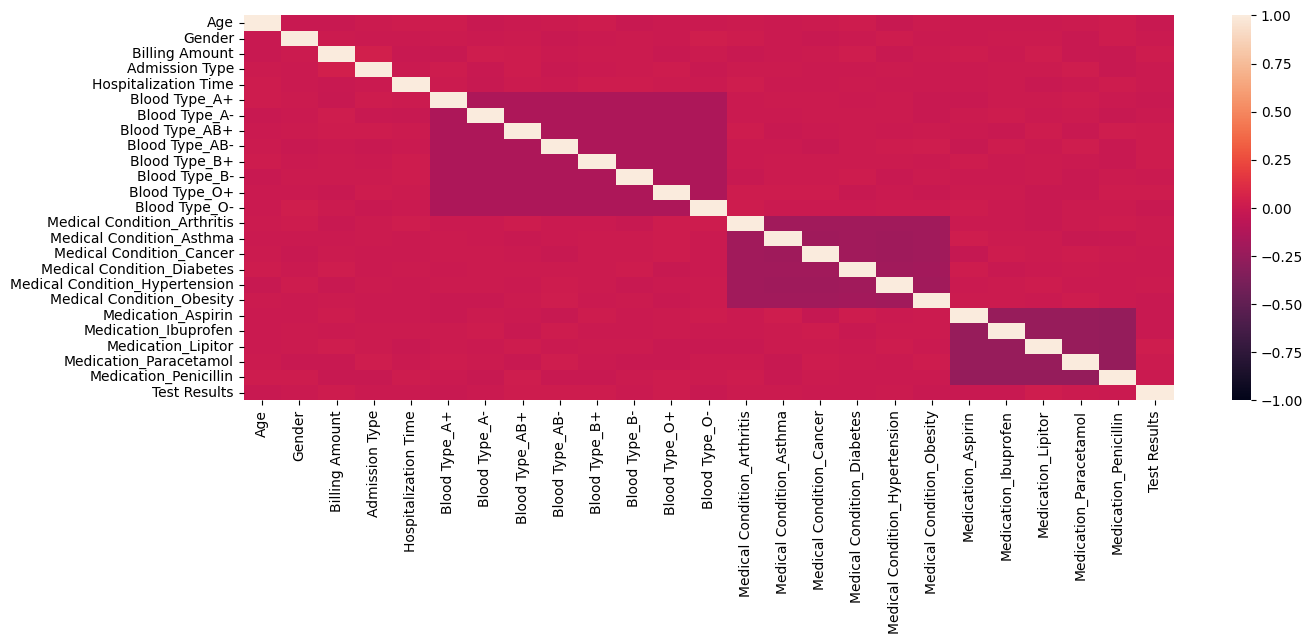

In [21]:
# Correlation matrix
plt.figure(figsize=(15, 5))
heatmap = sns.heatmap(matrix, vmin=-1, vmax=1)
plt.show()

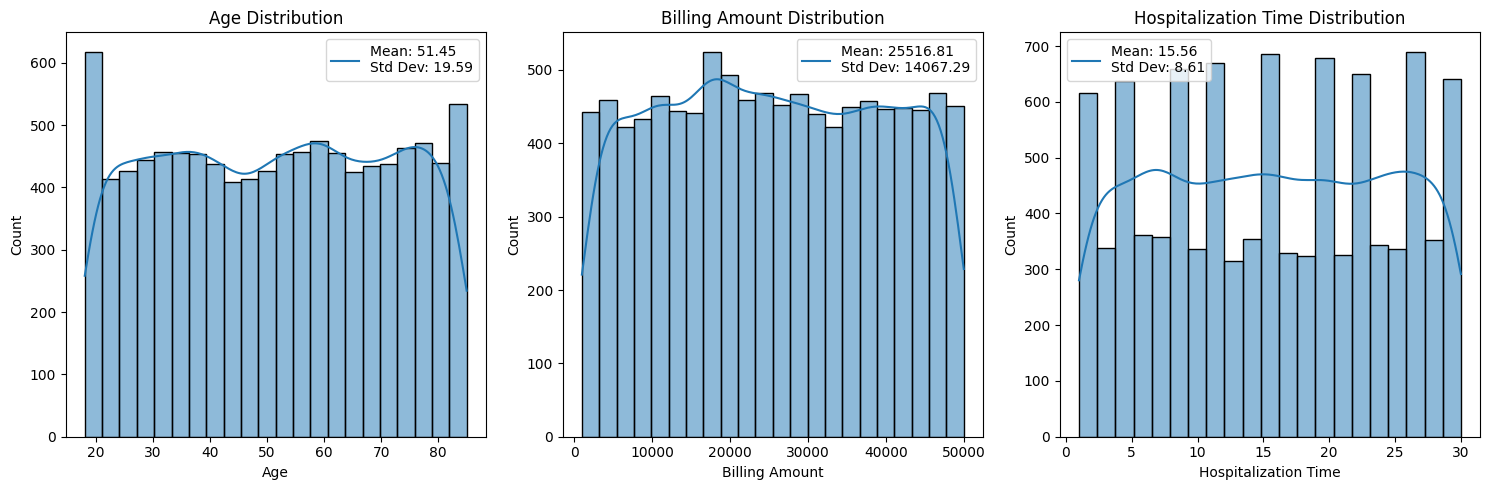

In [22]:
# Distribution
columns_for_distribution = ['Age', 'Billing Amount', 'Hospitalization Time']
fig, axs = plt.subplots(nrows=1, ncols=len(columns_for_distribution), figsize=(15, 5))
for i, col in enumerate(columns_for_distribution):
    sns.histplot(df[col], kde=True, ax=axs[i])  # Create distribution plot
    mean = df[col].mean()  # Calculate mean
    std_dev = df[col].std()  # Calculate standard deviation
    axs[i].legend([f'Mean: {mean:.2f}\nStd Dev: {std_dev:.2f}'])  # Set legend with mean and std dev
    axs[i].set_title(f'{col} Distribution')  # Set subplot title
plt.tight_layout()
plt.show()

Variance explained by 24 components: 
 [  5.35740258  10.68729457  15.95018178  21.18929286  26.26429198
  31.33043328  36.32737746  41.30753774  46.25458845  51.05586298
  55.83050521  60.58927994  65.33377731  70.03540047  74.72953054
  79.37887626  83.672698    87.84621853  91.95819691  96.04772791
 100.         100.         100.         100.        ] 
 



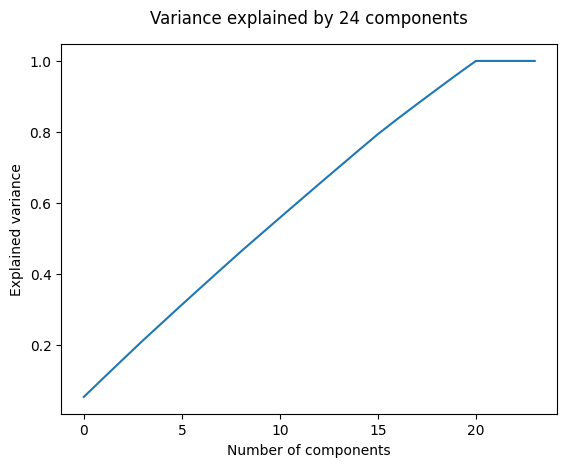

In [24]:
# PCA 24 components
X = df.iloc[:, :-1]  # Feature matrix
y = df.iloc[:, -1]  # Label vector
scaler = preprocessing.StandardScaler()  # Apply standard scaling to selected columns
scaler.fit(X)
X_scaled = scaler.transform(X)

pca_24 = PCA(n_components=24, random_state=123)
pca_24.fit(X_scaled)
X_pca_24 = pca_24.transform(X_scaled)
print(f'Variance explained by 24 components: \n {np.cumsum(pca_24.explained_variance_ratio_ * 100)} \n \n')
plt.plot(np.cumsum(pca_24.explained_variance_ratio_))
plt.title('Variance explained by 24 components', pad=15)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.show()

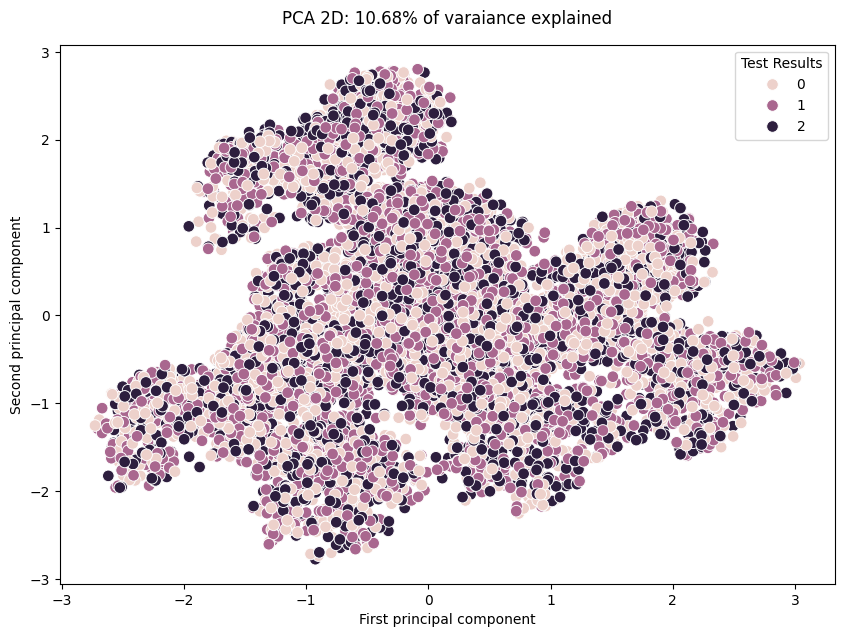

In [25]:
# PCA 2 components
pca_2 = PCA(n_components=2, random_state=123)
pca_2.fit(X_scaled)
X_pca_2 = pca_2.transform(X_scaled)
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca_2[:, 0], y=X_pca_2[:, 1], s=70, hue=df['Test Results'])
plt.title('PCA 2D: 10.68% of varaiance explained', pad=15)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.show()

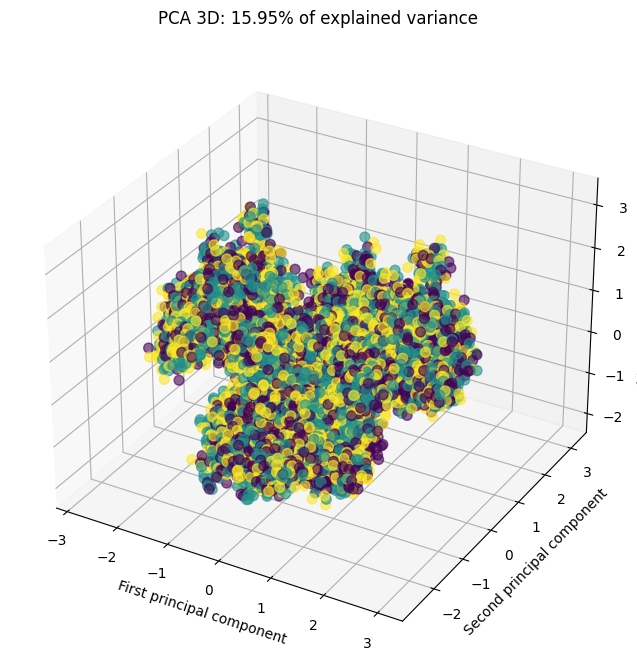

In [26]:
# PCA 3 components
pca_3 = PCA(n_components=3, random_state=123)
pca_3.fit(X_scaled)
X_pca_3 = pca_3.transform(X_scaled)
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection='3d')
sctt = ax.scatter3D(X_pca_3[:, 0], X_pca_3[:, 1], X_pca_3[:, 2],
                    c=df['Test Results'], s=50, alpha=0.6)
plt.title('PCA 3D: 15.95% of explained variance', pad=15)
ax.set_xlabel('First principal component')
ax.set_ylabel('Second principal component')
ax.set_zlabel('Third principal component')
plt.show()

# Model Selection

In dealing with multiclass prediction, One vs. Rest logic was adopted in order to simplify the task and allow easier separation of classes. Taking into consideration the large noise in the data that emerged through PCAs, in which it was impossible to identify patterns.

The training of hyperparameters related to different patterns was performed through the Grid Search CV algorithm, analyzing different prediction algorithms.

The best results were obtained by using of the **Multilayer Perceptron Classifier** algorithm, which was trained again first with a smaller training set dia, following validation then with a set given by the unification of train + val.

In [27]:
df = df.sample(frac=1)
X = df.iloc[:, :-1]  # Feature matrix
y = df.iloc[:, -1]  # Label vector

X_train, X_te_va, y_train, y_te_va = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% train set
X_val, X_test, y_val, y_test = train_test_split(X_te_va, y_te_va, test_size=0.5, random_state=42)  # 15% val and 15% test set

print(f"Training set size: {len(X_train)} \n")
print(f"Validation set size: {len(X_val)} \n")
print(f"Test set size: {len(X_test)} \n \n")

Training set size: 7000 

Validation set size: 1500 

Test set size: 1500 
 



In [28]:
scaler = preprocessing.MinMaxScaler()  # Apply Min-Max scaling to selected columns
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

## Grid Search of Different Models

In [ ]:
# One vs Rest SVC tuning
model_to_set = OneVsRestClassifier(SVC())
param_grid = {'estimator__C': [0.1, 1, 10, 100, 1000],
                'estimator__kernel': ['linear', 'rbf', 'poly'],
                'estimator__gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
print('One vs Rest with SVC tuning parameters:')
model_tuning = GridSearchCV(model_to_set, param_grid, cv=3, refit=True, verbose=3)
model_tuning.fit(X_train_scaled, y_train)
print(f'One vs. Rest with SVC best score: {model_tuning.best_score_} \n')
print(f'One vs Rest with SVC best params: {model_tuning.best_params_} \n')

In [ ]:
# One vs Rest Logistic Regression
model_to_set = OneVsRestClassifier(LogisticRegression())
param_grid = {'estimator__C': [0.1, 1.0, 10.0, 100.0],
                'estimator__solver': ['liblinear', 'lbfgs', 'saga'],
                'estimator__penalty': ['l1', 'l2']}
print('One vs Rest with LR tuning parameters:')
model_tuning = GridSearchCV(model_to_set, param_grid, cv=6, refit=True, verbose=3)
model_tuning.fit(X_train_scaled, y_train)
print(f'One vs. Rest with LR best score: {model_tuning.best_score_} \n')
print(f'One vs Rest with LR best params: {model_tuning.best_params_} \n')

In [ ]:
# One vs Rest KNN
model_to_set = OneVsRestClassifier(KNeighborsClassifier())
param_grid = {'estimator__n_neighbors': [3, 5, 7],
                'estimator__weights': ['uniform', 'distance'],
                'estimator__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
model_tuning = GridSearchCV(model_to_set, param_grid, cv=5,
                            refit=True, verbose=3)
print('One vs Rest with KNN tuning parameters:')
model_tuning.fit(X_train_scaled, y_train)
print(f'One vs. Rest with KNN best score: {model_tuning.best_score_} \n')
print(f'One vs Rest with KNN best params: {model_tuning.best_params_} \n')

In [ ]:
# One vs Rest MLP
model_to_set = OneVsRestClassifier(MLPClassifier())
param_grid = {'estimator__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
                'estimator__activation': ['identity', 'logistic', 'tanh','relu'],
                'estimator__solver': ['lbfgs','sgd', 'adam'],
                'estimator__alpha': [0.0001, 0.001, 0.01],
                'estimator__max_iter': [200, 500, 1000]}
print('One vs Rest with MLP tuning parameters:')
model_tuning = GridSearchCV(model_to_set, param_grid, cv=2, refit=True, verbose=3)
model_tuning.fit(X_train_scaled, y_train)
print(f'One vs. Rest with MLP best score: {model_tuning.best_score_} \n')
print(f'One vs Rest with MLP best params: {model_tuning.best_params_} \n')

## Model Tuning

In [30]:
# Model training
mlp_classifier = MLPClassifier(hidden_layer_sizes=(50,), activation='relu', solver='sgd', alpha=0.01,
                                max_iter=500, random_state=42)
ovr_classifier = OneVsRestClassifier(mlp_classifier)
ovr_classifier.fit(X_train_scaled, y_train)

OneVsRestClassifier(estimator=MLPClassifier(alpha=0.01,
                                            hidden_layer_sizes=(50,),
                                            max_iter=500, random_state=42,
                                            solver='sgd'))

Training accuracy vs validation accuracy: 0.35728571428571426 vs. 0.3373333333333333

Training precision vs validation precision: 0.3637048209300904 vs. 0.3705522486772486

Training recall vs validation recall: 0.34073856743702907 vs. 0.34223716266934073

Training f1 score vs validation f1 score: 0.23246720062008944 vs. 0.22953226842886662 
 



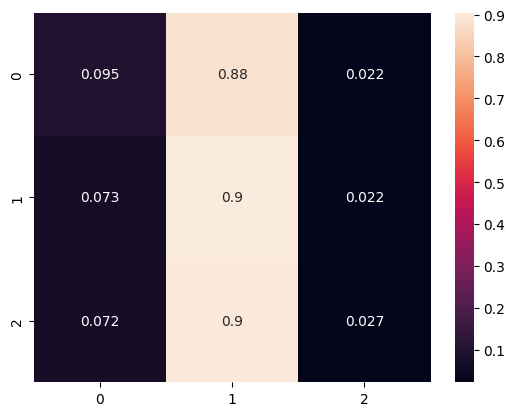

In [31]:
# Validation scores
y_pred_train = ovr_classifier.predict(X_train_scaled)
X_val_scaled = scaler.transform(X_val)
y_pred_val = ovr_classifier.predict(X_val_scaled)
print(f'Training accuracy vs validation accuracy: {accuracy_score(y_train, y_pred_train)} vs. {accuracy_score(y_val,y_pred_val)}\n')
print(f'Training precision vs validation precision: {precision_score(y_train, y_pred_train, average="macro")} vs. {precision_score(y_val, y_pred_val, average="macro")}\n')
print(f'Training recall vs validation recall: {recall_score(y_train, y_pred_train, average="macro")} vs. {recall_score(y_val, y_pred_val, average="macro")}\n')
print(f'Training f1 score vs validation f1 score: {f1_score(y_train, y_pred_train, average="macro")} vs. {f1_score(y_val, y_pred_val, average="macro")} \n \n')
cf_ms = confusion_matrix(y_val, y_pred_val, normalize='true')
sns.heatmap(cf_ms, annot=True)
plt.show()

In [32]:
# Final training
X_def = np.concatenate((X_train_scaled, X_val_scaled), axis=0)
y_def = np.concatenate((y_train, y_val), axis=0)
ovr_classifier.fit(X_def, y_def)
y_pred_def = ovr_classifier.predict(X_def)
print(f'Training accuracy after final trainig: {accuracy_score(y_def, y_pred_def)} \n')
print(f'Training precision after final training: {precision_score(y_def, y_pred_def, average="macro")} \n')
print(f'Training recall after final training: {recall_score(y_def, y_pred_def, average="macro")} \n')
print(f'Training f1 score after final training: {f1_score(y_def, y_pred_def, average="macro")} \n \n')

Training accuracy after final trainig: 0.3603529411764706 

Training precision after final training: 0.3739873380577041 

Training recall after final training: 0.349319852343318 

Training f1 score after final training: 0.27236091115677646 
 



# Model Assessment

Test accuracy: 0.34 

Test precision: 0.33379725409065264 

Test recall: 0.34229869418201647 

Test f1 score: 0.25517090447226415


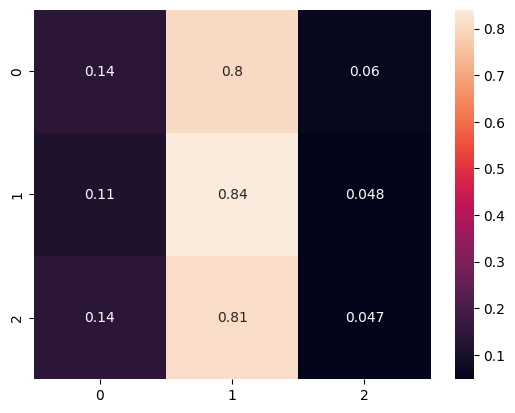

In [33]:
# Testing
X_test_scaled = scaler.transform(X_test)
y_pred_test = ovr_classifier.predict(X_test_scaled)
print(f'Test accuracy: {accuracy_score(y_test, y_pred_test)} \n')
print(f'Test precision: {precision_score(y_test, y_pred_test, average="macro")} \n')
print(f'Test recall: {recall_score(y_test, y_pred_test, average="macro")} \n')
print(f'Test f1 score: {f1_score(y_test, y_pred_test, average="macro")}')
cf_ma = confusion_matrix(y_test, y_pred_test, normalize='true')
sns.heatmap(cf_ma, annot=True)
plt.show()